<a href="https://colab.research.google.com/github/LuciaHrovatin/Credit_Analytics/blob/main/CreditAnalytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center>

# Credit Analytics
## Project 1
### CAS Introduction to Machine Learning in Finance and Insurance (Spring 2025)
#### Navarro Diego - <href>dnavarro@ethz.ch</href>
#### Rizzi Michele - <href>mirizzi@ethz.ch</href>
#### Hrovatin Lucia - <href>lhrovatin@ethz.ch</href>

</center>

In [ ]:
# Import all the Python libraries we are going to use

# Data Transformation
import numpy as np
import pandas as pd

# Data visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Statistical learning
from scipy.stats import bernoulli
import sklearn
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression # logistic regression model
from sklearn.metrics import log_loss # evaluation metric
from sklearn.metrics import accuracy_score # evaluation metric
from sklearn.metrics import confusion_matrix # evaluation metric
from sklearn.metrics import roc_curve # evaluation metric
from sklearn.metrics import roc_auc_score # evaluation metric
from sklearn.metrics import classification_report # evaluation metric
from sklearn import metrics # evaluation metric

# Deep Learning
try:
    import keras
except ImportError:
    !pip install keras --quiet
    import keras

try:
    import keras_tuner
except ImportError:
    !pip install keras-tuner --quiet
    import keras_tuner


In [ ]:
### Fix random seed for reproducibility
random_seed = 42
np.random.seed(random_seed)

# Exercise 1. Dataset features generation.

In [ ]:
# Number of samples
m = 20000  # training set
n = 10000  # test set

# Total number of samples
total_samples = m + n

# Generate xi1: age from the uniform distribution on [18, 80]
x1 = np.random.uniform(18, 80, total_samples)

# Generate xi2: monthly income (in CHF 1000) from the uniform distribution on [1, 15]
x2 = np.random.uniform(1, 15, total_samples)

# Generate xi3: salaried/self-employed in {0, 1}, where 0=salaried and 1=self-employed (probability of being self-employed is 10%)
x3 = np.random.choice([0, 1], total_samples, p=[0.9, 0.1])

# Combine the features into a single dataset
features = np.column_stack((x1, x2, x3))

# Combine the features in a DataFrame
features_df = pd.DataFrame(np.column_stack((x1, x2, x3)), columns=['Age', 'Income', 'Employment_type'])

# Print summary statistics
print("Dataset Summary Statistics:")
print(features_df.describe().round(2))

# Split the dataset into training and test sets
#training_set = features[:m]
#test_set = features[m:]

# Display the first few rows of the training set
#print("Training set (first 5 samples):")
#print(training_set[:5])

# Display the first few rows of the test set
#print("Test set (first 5 samples):")
#print(test_set[:5])

Dataset Summary Statistics:
            Age    Income  Employment_type
count  30000.00  30000.00          30000.0
mean      48.99      8.02              0.1
std       17.94      4.05              0.3
min       18.00      1.00              0.0
25%       33.35      4.51              0.0
50%       49.05      8.01              0.0
75%       64.55     11.51              0.0
max       80.00     15.00              1.0


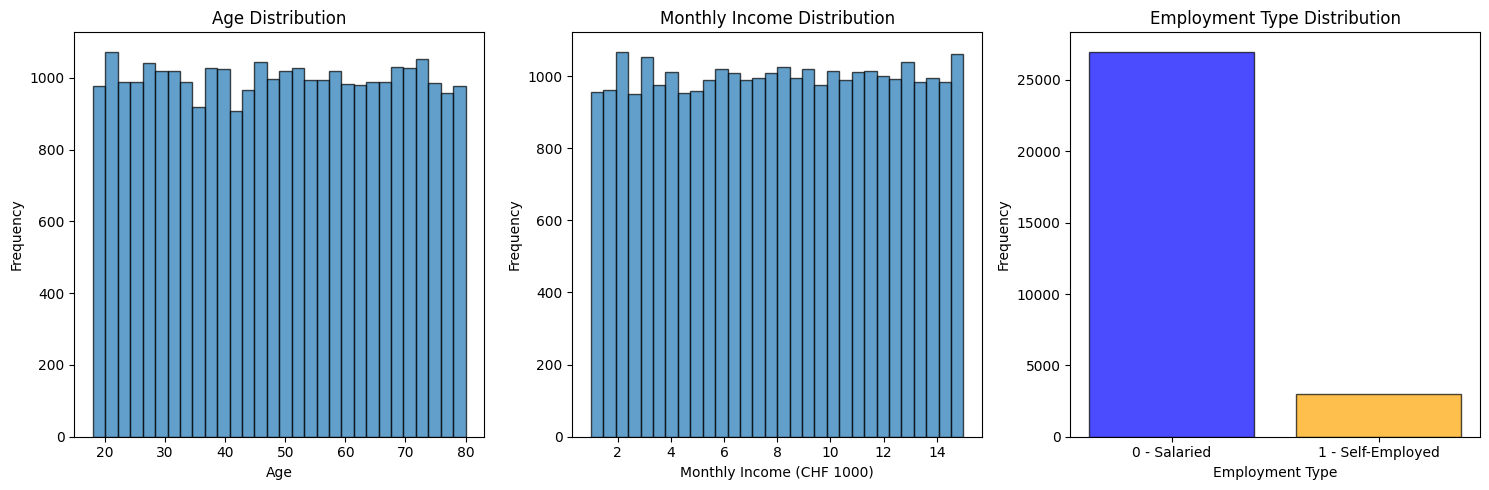

In [ ]:
# Plot histograms for each feature in the dataset
plt.figure(figsize=(15, 5))

# Histogram for xi1: age
plt.subplot(1, 3, 1)
plt.hist(x1, bins=30, edgecolor='k', alpha=0.7)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')

# Histogram for xi2: monthly income
plt.subplot(1, 3, 2)
plt.hist(x2, bins=30, edgecolor='k', alpha=0.7)
plt.title('Monthly Income Distribution')
plt.xlabel('Monthly Income (CHF 1000)')
plt.ylabel('Frequency')

# Histogram for xi3: salaried/self-employed
plt.subplot(1, 3, 3)
employment_counts = features_df['Employment_type'].value_counts()

# Create the bar chart
plt.bar(employment_counts.index, employment_counts.values,
        color=['blue', 'orange'], edgecolor='k', alpha=0.7)
plt.xticks(employment_counts.index, ['0 - Salaried', '1 - Self-Employed'])

#plt.hist(x3, bins=2, edgecolor='k', alpha=0.7)
plt.title('Employment Type Distribution')
plt.xlabel('Employment Type')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Exercise 2. Dataset labels generation.

In [ ]:
# Definition of logistic function
def logistic(z):
    return 1 / (1 + np.exp(-z))

# Define the functions p1 and p2
def p1(x):
    return logistic(-13.3 + 0.33 * x[:, 0] - 3.5 * x[:, 1] + 3 * x[:, 2])

def p2(x):
    def f(x):
        return 10 * ((x < 25) + (x > 75)) + 0
    return logistic(-5 + f(x[:, 0]) - 1.1 * x[:, 1] + x[:, 2])


prob_y1 = p1(features)
prob_y2 = p2(features)
y1 = bernoulli.rvs(prob_y1)
y2 = bernoulli.rvs(prob_y2)

# Create dataframes for the labels
df1 = pd.DataFrame({'Age': x1, 'Income': x2, 'Self-employed': x3, 'Default': y1})
df2 = pd.DataFrame({'Age': x1, 'Income': x2, 'Self-employed': x3, 'Default': y2})

In [ ]:
# Divide the dataset into training and test sets
training_set_x, test_set_x, training_set_y1, test_set_y1, training_set_y2, test_set_y2 = train_test_split(
    features, y1, y2, train_size=m, test_size=n, random_state=random_seed)

# Features normalization
scaler = preprocessing.StandardScaler()
training_set_x = scaler.fit_transform(training_set_x)
test_set_x = scaler.transform(test_set_x)

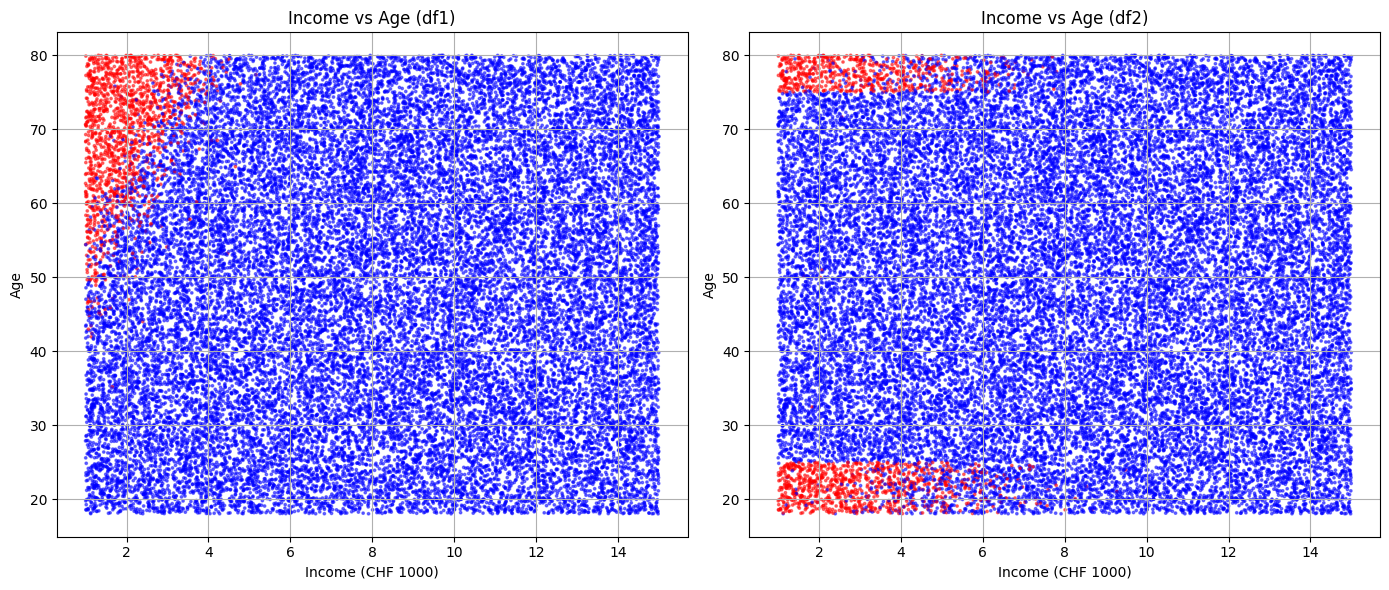

In [ ]:
plt.figure(figsize=(14, 6))

# Scatter plot for df1
plt.subplot(1, 2, 1)
colors = {0: 'blue', 1: 'red'}
plt.scatter(df1['Income'], df1['Age'], c=df1['Default'].apply(lambda x: colors[x]), alpha=0.5, s=3)
plt.title('Income vs Age (df1)')
plt.xlabel('Income (CHF 1000)')
plt.ylabel('Age')
plt.grid(True)

# Scatter plot for df2
plt.subplot(1, 2, 2)
plt.scatter(df2['Income'], df2['Age'], c=df2['Default'].apply(lambda x: colors[x]), alpha=0.5, s=3)
plt.title('Income vs Age (df2)')
plt.xlabel('Income (CHF 1000)')
plt.ylabel('Age')
plt.grid(True)

plt.tight_layout()
plt.show()

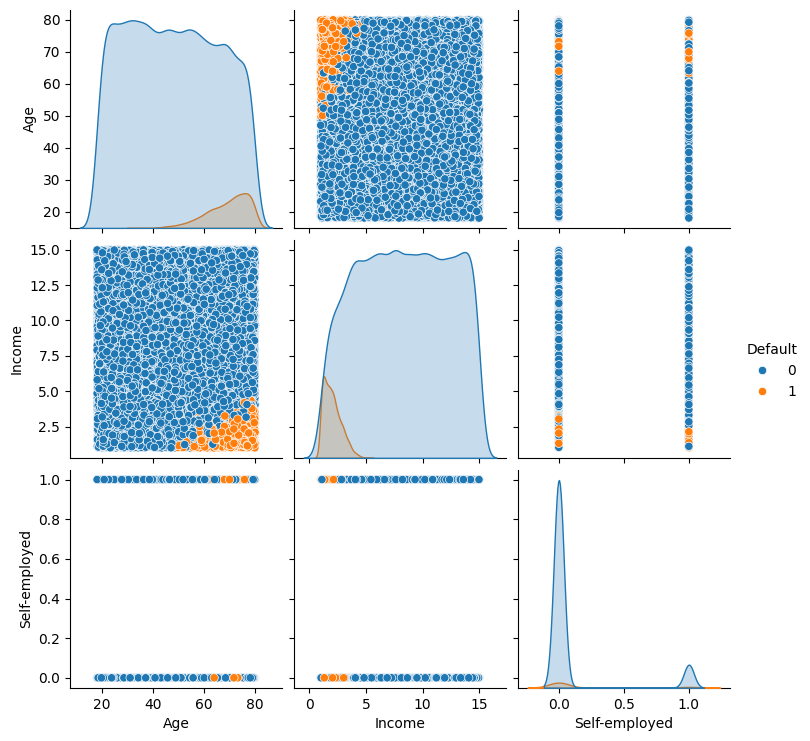

In [ ]:
sns.pairplot(df1, hue='Default')
plt.show()

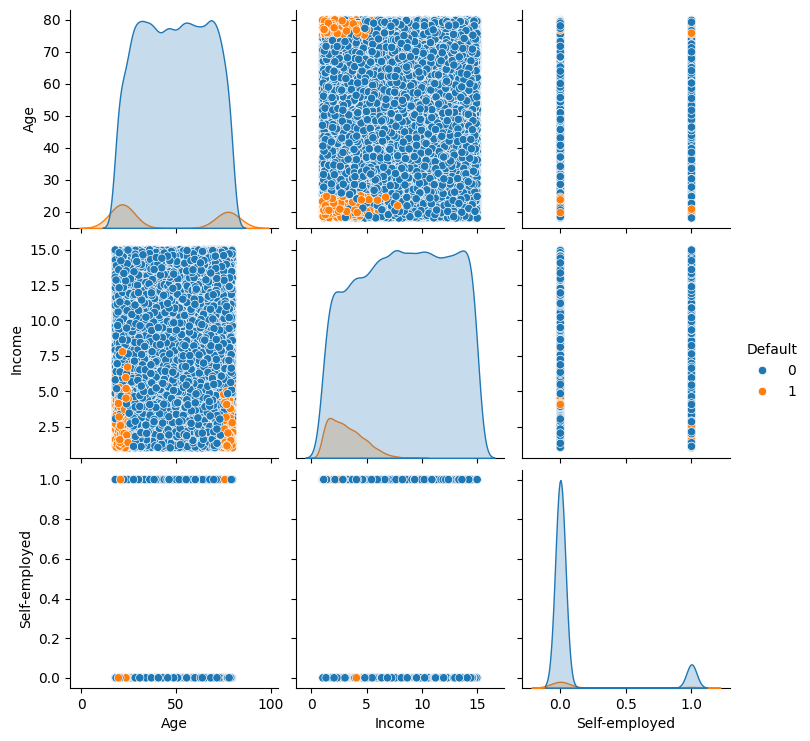

In [ ]:
# Create a pairplot for df2
sns.pairplot(df2, hue='Default')
plt.show()

# Exercise 3. Model implementations.

### 3a) Logistic regression (LR)

In [ ]:
# Implement and train a logistic regression model
logistic_regression_linear = LogisticRegression(penalty=None).fit(training_set_x, training_set_y1)
logistic_regression_nonlinear = LogisticRegression(penalty=None).fit(training_set_x, training_set_y2)

# Look at the parameters of the fitted model
print('Coefficients1:', logistic_regression_linear.coef_)
print('Intercept1:', logistic_regression_linear.intercept_)
print('Coefficients2:', logistic_regression_nonlinear.coef_)
print('Intercept2:', logistic_regression_nonlinear.intercept_)
# Predict the labels for the test set
predicted_y1 = logistic_regression_linear.predict(test_set_x)
predicted_y2 = logistic_regression_nonlinear.predict(test_set_x)

Coefficients1: [[  5.94310782 -14.00896557   0.8397555 ]]
Intercept1: [-24.54449504]
Coefficients2: [[-0.30733608 -2.05447753  0.06692196]]
Intercept2: [-4.38537233]


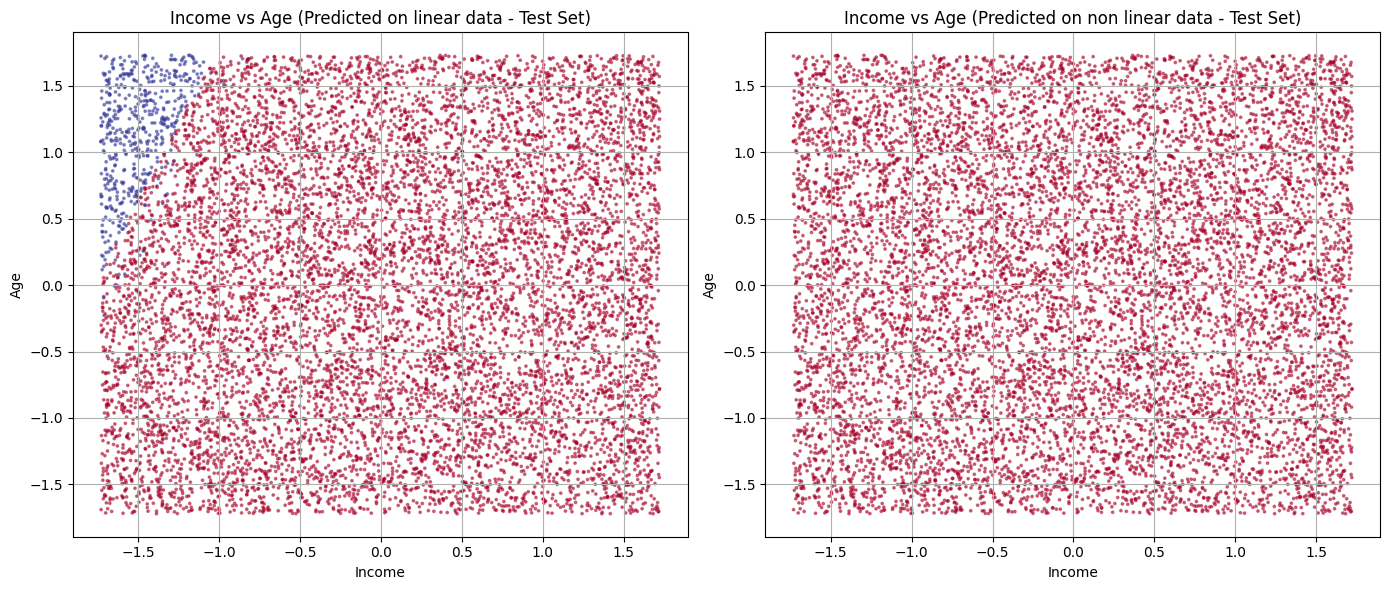

In [ ]:
plt.figure(figsize=(14, 6))

# Scatter plot for predicted_y1
plt.subplot(1, 2, 1)
plt.scatter(test_set_x[:, 1], test_set_x[:, 0], c=predicted_y1, cmap=plt.cm.RdYlBu, alpha=0.5, s=3)
plt.title('Income vs Age (Predicted on linear data - Test Set)')
plt.xlabel('Income')
plt.ylabel('Age')
plt.grid(True)

# Scatter plot for predicted_y2( really bad!)
plt.subplot(1, 2, 2)
plt.scatter(test_set_x[:, 1], test_set_x[:, 0], c=predicted_y2, cmap=plt.cm.RdYlBu, alpha=0.5, s=3)
plt.title('Income vs Age (Predicted on non linear data - Test Set)')
plt.xlabel('Income')
plt.ylabel('Age')
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# Compute cross-entropy loss for the training set
train_loss_y1 = log_loss(training_set_y1, logistic_regression_linear.predict_proba(training_set_x))
train_loss_y2 = log_loss(training_set_y2, logistic_regression_nonlinear.predict_proba(training_set_x))

# Compute cross-entropy loss for the test set
test_loss_y1 = log_loss(test_set_y1, logistic_regression_linear.predict_proba(test_set_x))
test_loss_y2 = log_loss(test_set_y2, logistic_regression_nonlinear.predict_proba(test_set_x))

print(f"Training Loss for y1: {train_loss_y1}")
print(f"Training Loss for y2: {train_loss_y2}")
print(f"Test Loss for y1: {test_loss_y1}")
print(f"Test Loss for y2: {test_loss_y2}")

Training Loss for y1: 0.03189401501937042
Training Loss for y2: 0.15476479191130785
Test Loss for y1: 0.03370512204177412
Test Loss for y2: 0.15102780802126828


NameError: name 'metrics' is not defined

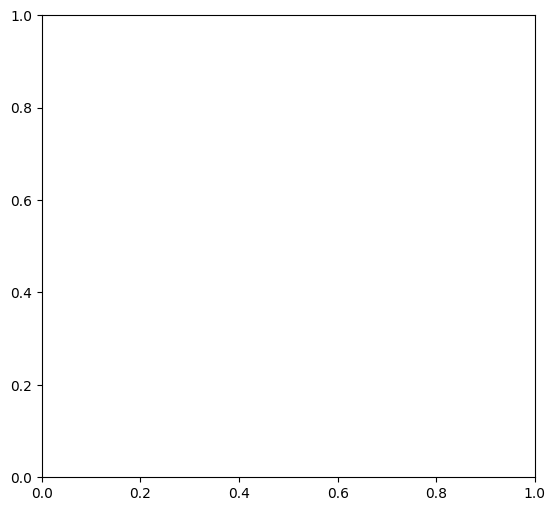

In [ ]:
# Confusion Matrix of the models
plt.figure(figsize=(14, 6))
class_names=[0,1] # prediction names
tick_marks = np.arange(len(class_names))

# Confusion Matrix Linear
plt.subplot(1, 2, 1)
cnf_matrix = metrics.confusion_matrix(test_set_y1, predicted_y1)
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="default" ,fmt='g', cbar=False)
plt.title('Confusion matrix of LR_linear')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

# Confusion Matrix nonLinear
plt.subplot(1, 2, 2)
cnf_matrix = metrics.confusion_matrix(test_set_y2, predicted_y2)
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="default" ,fmt='g', cbar=False)
plt.title('Confusion matrix of LR_nonlinear')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

### 3b) Neural network (NN)

In [ ]:
# Implement and train a neural network model

# Starting Parameters
lr = 0.001 # learning rate
batch_size = 1024 # size of batches in stochastic gradient descent
epochs = 100 # number of iterations on dataset

# Two hidden layers with 20 neurons each with ReLU activativation function
# Output layer with sigmoid activation function (needed to output probabilities!)
neural_network1 = keras.Sequential([keras.layers.Dense(20, activation='relu', input_shape=(training_set_x.shape[1],)),
                                   keras.layers.Dense(20, activation='relu'),
                                   keras.layers.Dense(1, activation='sigmoid')])

# Compile the network
# We choose Adam as gradient descent algorithm and cross-entropy as loss function
neural_network1.compile(optimizer=keras.optimizers.Adam(learning_rate=lr),
                       loss=keras.losses.BinaryCrossentropy())

neural_network2 = keras.Sequential([keras.layers.Dense(50, activation='relu', , input_shape=(training_set_x.shape[1],)),
                                   keras.layers.Dense(50, activation='relu'),
                                  keras.layers.Dense(50, activation='relu'),
                                  keras.layers.Dense(1, activation='sigmoid')])

neural_network2.compile(optimizer=keras.optimizers.Adam(learning_rate=lr),
                       loss=keras.losses.BinaryCrossentropy())

In [ ]:
# Train the model
history1_linear = neural_network1.fit(x=training_set_x, y=training_set_y1, batch_size=batch_size, epochs=epochs)
history1_nonlinear = neural_network1.fit(x=training_set_x, y=training_set_y2, batch_size=batch_size, epochs=epochs)

history2_linear = neural_network2.fit(x=training_set_x, y=training_set_y1, batch_size=batch_size, epochs=epochs)
history2_nonlinear = neural_network2.fit(x=training_set_x, y=training_set_y2, batch_size=batch_size, epochs=epochs)

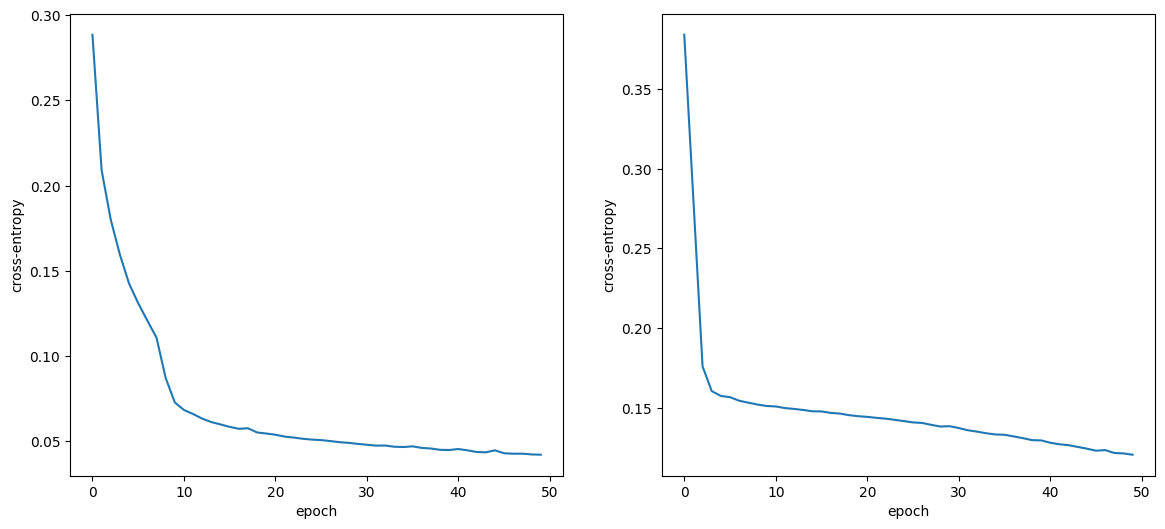

In [ ]:
# Training Performance
plt.figure(figsize=(14, 6))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history1_linear.history['loss'])
plt.ylabel('cross-entropy')
plt.xlabel('epoch')


# Loss
plt.subplot(1, 2, 2)
plt.plot(history1_nonlinear.history['loss'])
plt.ylabel('cross-entropy')
plt.xlabel('epoch')

plt.show()

In [ ]:
# Compute cross-entropy loss for the training set
train_loss_nn1_linear = neural_network1.evaluate(training_set_x, training_set_y1, verbose=1)
train_loss_nn1_nonlinear = neural_network1.evaluate(training_set_x, training_set_y2, verbose=1)
train_loss_nn2_linear = neural_network2.evaluate(training_set_x, training_set_y1, verbose=1)
train_loss_nn2_nonlinear = neural_network2.evaluate(training_set_x, training_set_y2, verbose=1)

# Compute cross-entropy loss for the test set
test_loss_nn1_linear = neural_network1.evaluate(test_set_x, test_set_y1, verbose=1)
test_loss_nn1_nonlinear = neural_network1.evaluate(test_set_x, test_set_y2, verbose=1)
test_loss_nn2_linear = neural_network2.evaluate(test_set_x, test_set_y1, verbose=1)
test_loss_nn2_nonlinear = neural_network2.evaluate(test_set_x, test_set_y2, verbose=1)

print(f"Training Loss for neural network 1 linear: {train_loss_nn1_linear}")
print(f"Training Loss for neural network 1 non linear: {train_loss_nn1_nonlinear}")
print(f"Test Loss for neural network 1 linear: {test_loss_nn1_linear}")
print(f"Test Loss for neural network 1 non linear: {test_loss_nn1_nonlinear}")

print(f"Training Loss for neural network 2 linear: {train_loss_nn2_linear}")
print(f"Training Loss for neural network 2 non linear: {train_loss_nn2_nonlinear}")
print(f"Test Loss for neural network 2 linear: {test_loss_nn2_linear}")
print(f"Test Loss for neural network 2 non linear: {test_loss_nn2_nonlinear}")

625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1269
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.1253
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1553
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0786
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1170
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1265
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1409
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0821
Training Loss for neural network 1 linear: 0.12395452708005905
Training Loss for neural network 1 non linear: 0.1213100254535675
Test Loss for neural network 1 linear: 0.12225303798913956
Test Loss for neural network 1 non linear: 0.12301445007324219
Training Loss for neural network 2 linear: 0.14901483058929443
Training Loss for neural network 2 non linear: 0.07832261174917221
Test Loss for neural network 2 linear: 0.14736993610858917
Test Loss for neural network 2 non linear: 0.07809161394834518


Tuner

In [ ]:
!pip install keras_tuner
import keras_tuner as kt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.7 MB/s eta 0:00:00


In [ ]:
def build_model(hp):
    model = keras.Sequential()

    # Tune the number of layers
    for i in range(hp.Int('num_layers', 1, 3)): #number of layers
        model.add(keras.layers.Dense(
            units=hp.Int('units_' + str(i), #number of neurons
                         min_value=16,
                         max_value=128,
                         step=16),
            activation=hp.Choice('activation_' + str(i), ['relu', 'tanh', 'leaky_relu']) #activation function
        ))

    model.add(keras.layers.Dense(1, activation='sigmoid')) # output layer

    # Tune the learning rate
    lr = hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr),
                  loss='binary_crossentropy',
                  metrics=['recall'])

    return model

def tuner_build_model(training_set_x, training_set_y, path, name):
  tuner = kt.RandomSearch(
        build_model,
        objective='val_recall',
        max_trials=10,
        executions_per_trial=1,
        directory=path,
        project_name=name
      )
  tuner.search(training_set_x, training_set_y, epochs=100, validation_split=0.2)
  return tuner

# Get the optimal hyperparameters
tuner_linear = tuner_build_model(training_set_x, training_set_y1, 'tuner', 'tuner_y1')
tuner_nonlinear = tuner_build_model(training_set_x, training_set_y2, 'tuner', 'tuner_y2')


#print(f"""
#The optimal number of layers is {best_hps.get('num_layers')}.
#The optimal number of units in each layer is {[best_hps.get('units_' + str(i)) for i in range(best_hps.get('num_layers'))]}.
#The optimal activation functions are {[best_hps.get('activation_' + str(i)) for i in range(best_hps.get('num_layers'))]}.
#The optimal learning rate is {best_hps.get('learning_rate')}.
#""")

Trial 10 Complete [00h 03m 49s]
val_recall: 0.870192289352417

Best val_recall So Far: 0.9519230723381042
Total elapsed time: 00h 37m 44s


In [ ]:
# Build the improved model using the optimal hyperparameters for y2
best_NN_linear = tuner_linear.hypermodel.build(tuner_linear.get_best_hyperparameters(num_trials = 1)[0])
history_linear = best_NN_linear.fit(x=training_set_x, y=training_set_y1, batch_size=batch_size, epochs=epochs)


Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.3295 - recall: 0.0000e+00
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1062 - recall: 0.0900
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0474 - recall: 0.8082
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0468 - recall: 0.8179
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0377 - recall: 0.8590
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0450 - recall: 0.8308
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0409 - recall: 0.8241
Epoch 8/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0430 - recall: 0.8491
Epoch 9/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0415 - recall: 0.8178
Epoch 10/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0408 - recall: 0.8454
Epoch 11/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0351 - recall: 0.8472
Epoch 12/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0421 - recall: 0.85

In [ ]:
best_NN_nonlinear = tuner_nonlinear.hypermodel.build(tuner_nonlinear.get_best_hyperparameters(num_trials = 1)[0])
history_nonlinear = best_NN_nonlinear.fit(x=training_set_x, y=training_set_y2, batch_size=batch_size, epochs=100)

Epoch 1/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.8746 - recall: 0.1927
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.3202 - recall: 0.0584
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1781 - recall: 0.0063
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.1564 - recall: 0.0000e+00
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1538 - recall: 0.0000e+00
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1548 - recall: 0.0000e+00
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1538 - recall: 0.0000e+00
Epoch 8/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1589 - recall: 0.0000e+00
Epoch 9/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1520 - recall: 0.0000e+00
Epoch 10/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1549 - recall: 0.0000e+00
Epoch 11/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1558 - recall: 0.0000e+00
Epoch 12/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7m

In [ ]:
# Compute cross-entropy loss for the test set linear
test_loss_nn1 = best_NN_linear.evaluate(test_set_x, test_set_y1, verbose=1)

# Compute cross-entropy loss for the test set
test_loss_nn2 = best_NN_nonlinear.evaluate(test_set_x, test_set_y2, verbose=1)

print(f"Test Loss for neural network linear: {test_loss_nn1}")
print(f"Test Loss for neural network non linear: {test_loss_nn2}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0339 - recall: 0.8955
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0749 - recall: 0.4537
Training Loss for neural network 2: [0.034116022288799286, 0.8937875628471375]
Test Loss for neural network 2: [0.07114363461732864, 0.4800758957862854]


### 3c) ROC curves and AUC scores

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


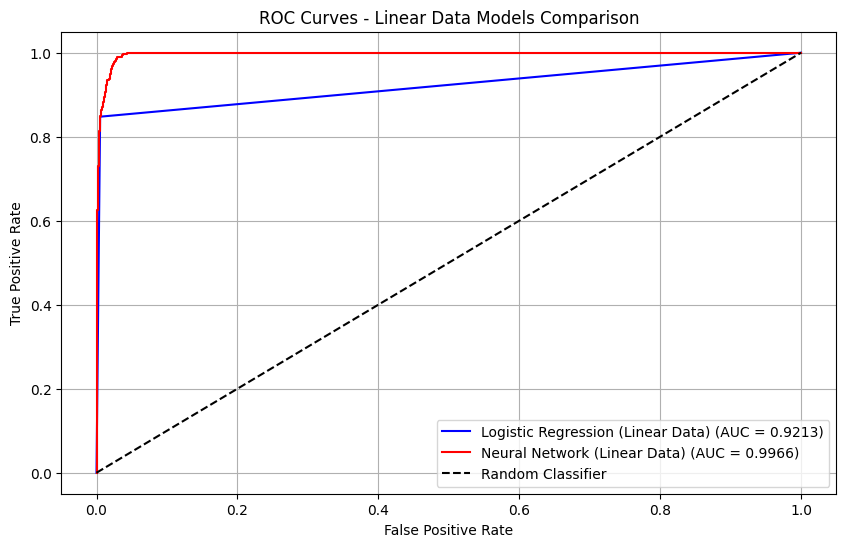

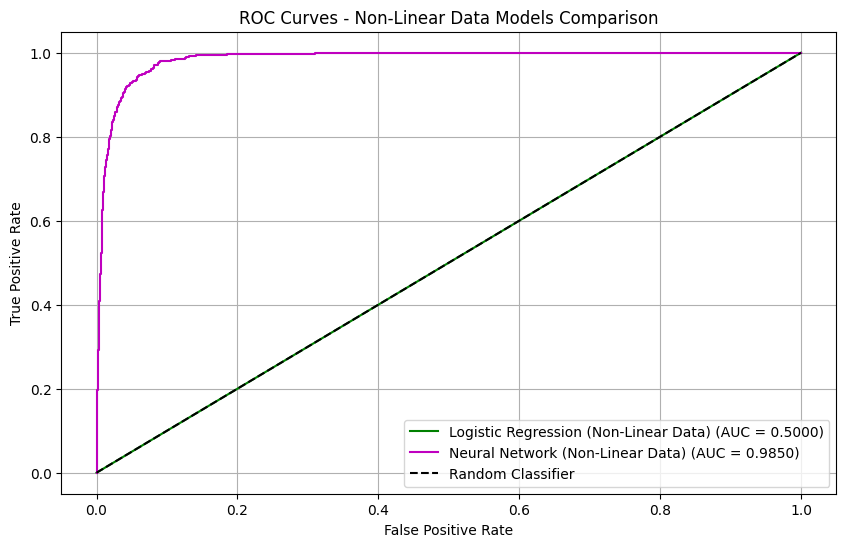

Linear Data Comparison:
Logistic Regression AUC: 0.9213
Neural Network AUC: 0.9966

Non-Linear Data Comparison:
Logistic Regression AUC: 0.5000
Neural Network AUC: 0.9850


In [ ]:
# Plot the ROC curves and compute the AUC scores
# You can use roc_auc_score and roc_curve from sklearn.metrics
# Plot the ROC curves and compute the AUC scores
from sklearn.metrics import roc_curve, roc_auc_score

# Get predictions for all models
# Linear data models
logistic_linear_test_pred = predicted_y1
neural_linear_test_pred = best_NN_linear.predict(test_set_x)

# Non-linear data models
logistic_nonlinear_test_pred = predicted_y2
neural_nonlinear_test_pred = best_NN_nonlinear.predict(test_set_x)

# Compute ROC curves and AUC scores
# Linear data comparison
fpr_logistic_linear, tpr_logistic_linear, _ = roc_curve(test_set_y1, logistic_linear_test_pred)
auc_logistic_linear = roc_auc_score(test_set_y1, logistic_linear_test_pred)

fpr_neural_linear, tpr_neural_linear, _ = roc_curve(test_set_y1, neural_linear_test_pred)
auc_neural_linear = roc_auc_score(test_set_y1, neural_linear_test_pred)

# Non-linear data comparison
fpr_logistic_nonlinear, tpr_logistic_nonlinear, _ = roc_curve(test_set_y2, logistic_nonlinear_test_pred)
auc_logistic_nonlinear = roc_auc_score(test_set_y2, logistic_nonlinear_test_pred)

fpr_neural_nonlinear, tpr_neural_nonlinear, _ = roc_curve(test_set_y2, neural_nonlinear_test_pred)
auc_neural_nonlinear = roc_auc_score(test_set_y2, neural_nonlinear_test_pred)

# Plot ROC curves for linear data comparison
plt.figure(figsize=(10, 6))
plt.plot(fpr_logistic_linear, tpr_logistic_linear, 'b-', label=f'Logistic Regression (Linear Data) (AUC = {auc_logistic_linear:.4f})')
plt.plot(fpr_neural_linear, tpr_neural_linear, 'r-', label=f'Neural Network (Linear Data) (AUC = {auc_neural_linear:.4f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves - Linear Data Models Comparison')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Plot ROC curves for non-linear data comparison
plt.figure(figsize=(10, 6))
plt.plot(fpr_logistic_nonlinear, tpr_logistic_nonlinear, 'g-', label=f'Logistic Regression (Non-Linear Data) (AUC = {auc_logistic_nonlinear:.4f})')
plt.plot(fpr_neural_nonlinear, tpr_neural_nonlinear, 'm-', label=f'Neural Network (Non-Linear Data) (AUC = {auc_neural_nonlinear:.4f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves - Non-Linear Data Models Comparison')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Print AUC scores
print("Linear Data Comparison:")
print(f"Logistic Regression AUC: {auc_logistic_linear:.4f}")
print(f"Neural Network AUC: {auc_neural_linear:.4f}")
print("\nNon-Linear Data Comparison:")
print(f"Logistic Regression AUC: {auc_logistic_nonlinear:.4f}")
print(f"Neural Network AUC: {auc_neural_nonlinear:.4f}")

# Exercise 4. Comparison of lending strategies

In [ ]:
# Implement a function to compute the Value at Risk (VaR) at level alpha on the vector x

def var(x, alpha):
    # Write your code here and return your VaR(alpha) estimate
    return None

In [ ]:
# Implement strategy (i), plot the P&L histogram and compute VaR(95%) of the losses

# Implement strategy (ii), plot the P&L histogram and compute VaR(95%) of the losses

# Implement strategy (iii), plot the P&L histogram and compute VaR(95%) of the losses